# STEAM RECOMMENDER SYSTEM

### Importing necessary packages

In [1]:
# installing the library suprise
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 27kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1675389 sha256=1b01f88c1237de79479d0287158fc6325b4f15eae39242cda872f0b40a4ee4eb
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [2]:
# importing necessary packages
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel

from collections import Counter

from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
nltk.download('punkt')
nltk.download('stopwords')
import re
import string

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Importing the cleaned data set

In [3]:
# unziping the folder containing the steam_rs.csv data
!unzip steam_rs.zip

Archive:  steam_rs.zip
  inflating: steam_rs.csv            


In [0]:
# importing the data set
steam = pd.read_csv('steam_rs.csv')

In [5]:
# displaying 5 rows of the data frame
steam.head()

,id,appid,name,purchase,hours_of_play,developer,publisher,positive,negative,release_date,english,platforms,required_age,categories,genres,steamspy_tags,achievements,average_playtime,median_playtime,owners,detailed_description,about_the_game,short_description,price,rank
0,151603712,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
1,151603712,570,Dota 2,play,0.5,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
2,187131847,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
3,187131847,570,Dota 2,play,2.3,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
4,176410694,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113


In [6]:
# getting name count
steam_name_count = pd.DataFrame(steam.groupby('name').size().sort_values(), columns=['count'])
steam_name_count

,count
name,
Putt-Putt and Pep's Dog on a Stick,1
Battle Mages,1
Gold Rush! Anniversary,1
Vertex Dispenser,1
Verde Station,1
...,...
Counter-Strike,1424
Left 4 Dead 2,1752
Unturned,2632


In [7]:
# checking games based on their rank
steam.groupby(['name'])['rank'].mean().reset_index()

,name,rank
0,0RBITALIS,71.785714
1,10 Second Ninja,85.897436
2,"10,000,000",89.694459
3,100% Orange Juice,93.090154
4,1000 Amps,78.877888
...,...,...
2292,rFactor 2,86.908517
2293,resident evil 4 / biohazard 4,86.958567
2294,rymdkapsel,82.568807
2295,samurai_jazz,68.181818


In [8]:
# obtaining the frequencies for each of the ranks given to a specific game
ratings = steam['rank'].value_counts()
ratings

84.951130    9682
94.121113    4646
90.935142    2632
97.067529    1752
97.461406    1424
             ... 
22.826087       1
85.915493       1
55.185185       1
66.812227       1
82.377049       1
Name: rank, Length: 2182, dtype: int64

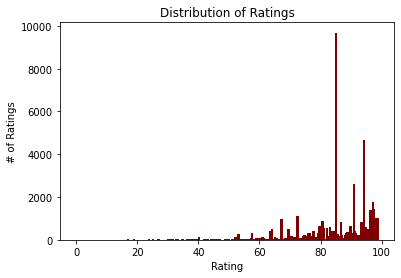

In [9]:
# plotting distribution of ratings
ratings_sorted = sorted(list(zip(ratings.index, ratings)))
plt.bar([r[0] for r in ratings_sorted], [r[1] for r in ratings_sorted], color='maroon')
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

From this graph above, most of the ratings seem to be around 85%, as well as that it can be seen that there seem to be a very small amount of games rated less than 50%.

In [10]:
# checking users with the highest amount of hours spent playing 
steam.groupby('id')['hours_of_play'].agg(np.sum).sort_values(ascending=False)[0:10]

id
73017395     11754.0
100630947    10445.7
153382649     9640.0
130882834     7765.0
52567955      7704.8
14544587      7242.7
121199670     6755.2
67694595      6269.7
86256882      6242.7
12660489      6061.5
Name: hours_of_play, dtype: float64

In [11]:
# obtaining a count of all the unique ids and app ids
print("Unique player ids :", steam["id"].nunique())
print("Unique app ids :", steam["name"].nunique())

Unique player ids : 10350
Unique app ids : 2297


Text(0.5, 1.0, 'Hours of play per game')

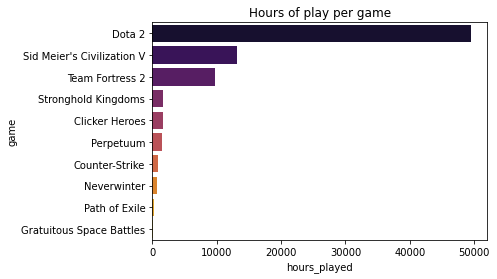

In [19]:
# graphing the amount of hours spent on a game
top = 10

user_counts = steam.groupby('id')['hours_of_play'].agg(np.sum).sort_values(ascending=False)[0:top]
mask = steam['id'].isin(user_counts.index)
df_infos_user = steam.loc[mask].loc[steam['purchase'] == 'play']
hours_played = df_infos_user.groupby('name')['hours_of_play'].agg(np.sum).sort_values(ascending=False)
hours_played = pd.DataFrame({'game': hours_played.index, 'hours_played': hours_played.values})[0:10]

sns.barplot(y = 'game', x = 'hours_played', data = hours_played, palette='inferno')
plt.title("Hours of play per game")

From this graph it can be seen that Dota 2 is the most played steam game next to Sid meier's civilization V and team fortress 2.

Text(0.5, 1.0, 'Users that purchased/played a game')

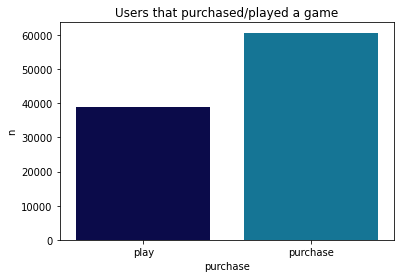

In [21]:
# checking amount of users that have either played or purchased a game
actions = steam.groupby('purchase')['purchase'].agg('count')
actions = pd.DataFrame({'purchase': actions.index, 'n': actions.values})
sns.barplot(x = 'purchase', y = 'n', data = actions, palette='ocean')
plt.title("Users that purchased/played a game")

From this graph it indicates that most users have purchased a game from steam, but have not yet played it yet.

# Content based model

Content based recommender systems predict what the user likes based on what they have liked in the past. This creates personlizes recommendations for the user based on interests, and other such factors. To recommend a user similar items that the user has previously liked, TFIDF can be used, as it helps identify which item is similar to each other. Each of these items are represented using TFIDF vectors.
<br><br>
TFIDF is a very crucial in building the recommender system. Term frequency (TF) is the frequencies of a specific word in a document, and inverse document frequency (IDF) is the universe of document frequencies throughout the entire corpus of documents.

In [22]:
# displaying the data frame
steam.head()

,id,appid,name,purchase,hours_of_play,developer,publisher,positive,negative,release_date,english,platforms,required_age,categories,genres,steamspy_tags,achievements,average_playtime,median_playtime,owners,detailed_description,about_the_game,short_description,price,rank
0,151603712,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
1,151603712,570,Dota 2,play,0.5,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
2,187131847,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
3,187131847,570,Dota 2,play,2.3,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
4,176410694,570,Dota 2,purchase,0.0,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113


In [23]:
# checking the current shape of the data frame
steam.shape

(99632, 25)

In [0]:
# dropping the duplicate ids, and keeping the most recent ones as making sure it dosent remove all the unique games in the data frame
steam.drop_duplicates(subset = ['id', 'name'],
                     keep = 'last', inplace = True)

In [25]:
# checking the shape after removing duplicates
steam.shape

(60446, 25)

Removing the duplicate ids reduced the size of the data frame from its inital 99632 rows to 60446 rows.

In [26]:
# obtaining a count of all the unique ids and app ids
print("Unique player ids :", steam["id"].nunique())
print("Unique app ids :", steam["name"].nunique())

Unique player ids : 10350
Unique app ids : 2297


From here it can be seen that removing the duplicate ids kept all of the unique app ids. It also kept all the unique player ids.

Following this i will be selecting key features that i will want to base my recommedations on, and i will be selecting 'name', 'genre', 'categories', and 'short_description' as my main features.

In [0]:
# creating tags for each words
tags = {}
for col in ['name', 'genres', 'categories', 'short_description']:
    for id in steam['appid'].unique():
        for i in steam[steam['appid'] == id][col]:
            if id in tags:
                tags[id].append(' '.join(i.lower().split('|')))
            else:
                tags[id] = i.lower().split('|')

In [0]:
# creating a list from the tags
tags_list = list(tags.values())

In [29]:
# viewing tags
tags_list[:2]

[['dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'dota 2',
  'd

In [0]:
# getting all the english stopwords and storing them in stopwords_list
stopwords_list = stopwords.words('english')

In [0]:
# removing punctuation
stopwords_list += list(string.punctuation)

In [32]:
# checking most common words in the stop words list
most_common = FreqDist(stopwords_list)
most_common.most_common(20)

[('i', 1),
 ('me', 1),
 ('my', 1),
 ('myself', 1),
 ('we', 1),
 ('our', 1),
 ('ours', 1),
 ('ourselves', 1),
 ('you', 1),
 ("you're", 1),
 ("you've", 1),
 ("you'll", 1),
 ("you'd", 1),
 ('your', 1),
 ('yours', 1),
 ('yourself', 1),
 ('yourselves', 1),
 ('he', 1),
 ('him', 1),
 ('his', 1)]

In [33]:
# checking length of all the stop words
len(most_common)

211

In [0]:
# a function that removes stopwords, tozenizes the article and makes each of the tokens lowercase
def process_article(article):
    
    ''' a function that removes stopwords, tozenizes the article and makes each of the tokens lowercase.'''

    article = ' '.join(article)
    tokens = word_tokenize(article) 
    tokens_2 = [] 

    
    for token in tokens:
    
        if token.lower() not in stopwords_list:
            tokens_2.append(token.lower())
                
    return tokens_2

In [0]:
# preprocessing the data
processed_data = list(map(process_article, tags_list))

In [36]:
# checking the length of the processed data
len(processed_data)

2297

In [37]:
len(steam['appid'].unique())

2297

In [38]:
# obtaining the total vocabulary size
total_vocab = set()
for doc in processed_data:
    total_vocab.update(doc)
len(total_vocab)

11896

In [0]:
# concatenating every article into a single list
articles_concat = []
for doc in processed_data:
    articles_concat += doc

In [0]:
# passing articles_concant to FreqDist() in order to get the most common words
freqdist = FreqDist(articles_concat)

In [41]:
# obtaining the 20 most common words
most_common = freqdist.most_common(20)
most_common

[('steam', 122235),
 ('action', 55408),
 ('multi-player', 48230),
 ('single-player', 42170),
 ('cards', 37281),
 ('trading', 37106),
 ('achievements', 36820),
 ('play', 32801),
 ('co-op', 32019),
 ('support', 30384),
 ('controller', 27867),
 ('online', 26192),
 ('game', 26064),
 ('free', 24311),
 ('indie', 23773),
 ("'s", 23168),
 ('cloud', 22937),
 ('2', 21595),
 ('multiplayer', 20859),
 ('adventure', 20085)]

Text(0.5, 1.0, 'Most common words')

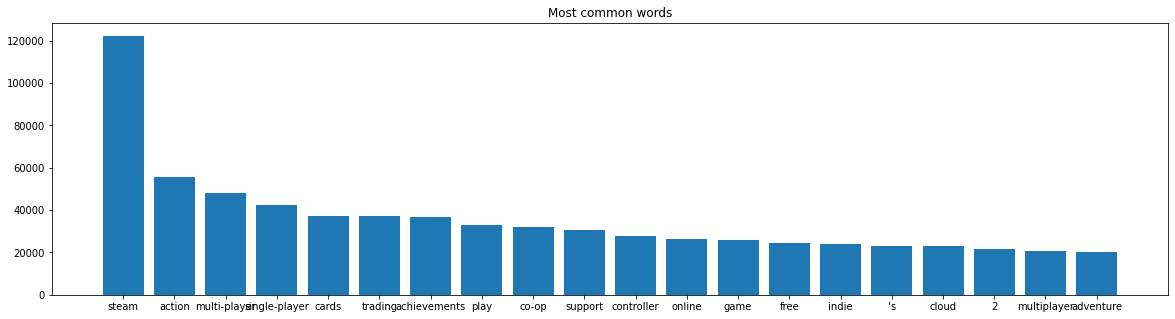

In [42]:
# graphing the 20 most common words
plt.figure(figsize = (20, 5))
plt.bar([word[0] for word in most_common], [word[1] for word in most_common])
plt.title('Most common words')

'steam', 'action', 'multi-player', 'single-player' and 'cards' are the most appearing words according to the results from the graph.

In [0]:
# instatiating TfidfVectorizer() and assiging it to the variable tfidf
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), stop_words=stopwords_list)

In [0]:
tags_list_2 = [' '.join(x) for x in tags_list]

In [0]:
tfidf_matrix = tfidf.fit_transform(tags_list_2)

In [46]:
tfidf_matrix.shape

(2297, 62923)

In [0]:
#instantiating TruncatedSVD()
svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)

In [0]:
#fit and transform the vectorized tf-idf matrix 
tf_idf_data_train_svd = svd.fit_transform(tfidf_matrix)

In [49]:
print(svd.explained_variance_ratio_.sum())

0.3578216558474654


### Calculating cosine similarities

In [0]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

### Making recommendations

In [0]:
# creating a Series for the game titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(steam.name)

In [0]:
#  defining the function that takes in game title 
# as input and returns the top 10 recommended games
def recommendations(title, cosine_similarities = cosine_similarities):
    
    # initializing the empty list of recommended movies
    recommended_games = []
    
    # gettin the index of the game that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar games
    score_series = score_series
    top_10_indexes = list(score_series[1:11].index)
    
    # populating the list with the titles of the best 10 matching games
    for i in top_10_indexes:
        recommended_games.append(list(steam.name)[i])

    return recommended_games

In [53]:
recommendations('Dota 2')

['Dota 2',
 'Dota 2',
 'Dota 2',
 'Dota 2',
 'Dota 2',
 'Dota 2',
 'Dota 2',
 'Dota 2',
 'Dota 2',
 'Dota 2']

In [0]:
steam_2 = steam.reset_index()

In [56]:
steam_2.head()

,index,id,appid,name,purchase,hours_of_play,developer,publisher,positive,negative,release_date,english,platforms,required_age,categories,genres,steamspy_tags,achievements,average_playtime,median_playtime,owners,detailed_description,about_the_game,short_description,price,rank
0,1,151603712,570,Dota 2,play,0.5,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
1,3,187131847,570,Dota 2,play,2.3,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
2,5,176410694,570,Dota 2,play,9.1,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
3,7,197278511,570,Dota 2,play,0.5,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113
4,9,197455089,570,Dota 2,play,3.4,Valve,Valve,1097301,194384,2013-07-09,1,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,23944,801,100000000-200000000,<strong>The most-played game on Steam.</strong...,<strong>The most-played game on Steam.</strong...,"Every day, millions of players worldwide enter...",0.0,84.95113


In [0]:
steam_id_tag = steam_2['appid']
indices = pd.Series(steam_2.index, index=steam_2['appid'])

In [58]:
indices.head()

appid
570    0
570    1
570    2
570    3
570    4
dtype: int64

In [0]:
def get_most_similar_games(appid, n = 20):
    idx = indices[appid]
    idx = np.array(idx, dtype=np.integer)

    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:n]

    game_indices = [i[0] for i in sim_scores]

    recs = pd.DataFrame(columns= steam_2.columns)
    for i in steam_id_tag.loc[game_indices]:

        if i != appid:
            recs = recs.append(steam_2[steam_2['appid'] == i])
    return recs

In [60]:
len(cosine_similarities)

2297

In [61]:
len(indices)

60446

In [62]:
steam_2[steam_2['appid'] == 20]

,index,id,appid,name,purchase,hours_of_play,developer,publisher,positive,negative,release_date,english,platforms,required_age,categories,genres,steamspy_tags,achievements,average_playtime,median_playtime,owners,detailed_description,about_the_game,short_description,price,rank
42109,72457,62923086,20,Team Fortress Classic,purchase,0.0,Valve,Valve,4178,760,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,3.99,84.609154
42110,72459,11373749,20,Team Fortress Classic,play,0.3,Valve,Valve,4178,760,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,3.99,84.609154
42111,72460,5270060,20,Team Fortress Classic,purchase,0.0,Valve,Valve,4178,760,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,3.99,84.609154
42112,72461,64350600,20,Team Fortress Classic,purchase,0.0,Valve,Valve,4178,760,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,3.99,84.609154
42113,72462,2428602,20,Team Fortress Classic,purchase,0.0,Valve,Valve,4178,760,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,3.99,84.609154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42470,72844,20772968,20,Team Fortress Classic,purchase,0.0,Valve,Valve,4178,760,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,3.99,84.609154
42471,72845,14421986,20,Team Fortress Classic,purchase,0.0,Valve,Valve,4178,760,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,3.99,84.609154
42472,72846,622362,20,Team Fortress Classic,purchase,0.0,Valve,Valve,4178,760,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,3.99,84.609154
42473,72847,117345810,20,Team Fortress Classic,purchase,0.0,Valve,Valve,4178,760,1999-04-01,1,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,277,62,5000000-10000000,One of the most popular online action games of...,One of the most popular online action games of...,One of the most popular online action games of...,3.99,84.609154


In [63]:
get_most_similar_games(20)

IndexError: ignored

In [0]:
from sklearn.metrics.pairwise import sigmoid_kernel

#create an instance of the sigmoid kernel class
sig = sigmoid_kernel(tfidf_matrix, tfidf_matrix) #compare how overviews are related to each other

In [79]:
#sigmoid score for all details comparisons with the title at first few indices. Note that the higher the sig score 
#the more similar the title
print('Similarities of all movies with first movie in the dataframe: \n', sig[0], '\n')

print('First five comparisons for our first and second movie in the dataframe: \n', sig[0,0:5], sig[1,0:5])

Similarities of all movies with first movie in the dataframe: 
 [0.76160083 0.76159481 0.76159492 ... 0.76159431 0.76159419 0.76159416] 

First five comparisons for our first and second movie in the dataframe: 
 [0.76160083 0.76159481 0.76159492 0.76159478 0.76159443] [0.76159481 0.76160083 0.76159544 0.76159501 0.76159451]


In [96]:
data = steam.groupby('appid').agg({'id':'first',
                                          'name':'first'}).reset_index()
data.head()

,appid,id,name
0,10,30695285,Counter-Strike
1,20,62923086,Team Fortress Classic
2,30,30695285,Day of Defeat
3,40,30695285,Deathmatch Classic
4,60,30695285,Ricochet


In [0]:
indices = pd.Series(data.index, index=data['name']).drop_duplicates()

In [98]:
indices[:2000] #arbitrary access of the movie list

name
Counter-Strike              0
Team Fortress Classic       1
Day of Defeat               2
Deathmatch Classic          3
Ricochet                    4
                         ... 
Cultures - Northland     1995
Tales of Zestiria        1996
Fair Strike              1997
Curse of Mermos          1998
King of Dragon Pass      1999
Length: 2000, dtype: int64

In [99]:
indices['Dota 2']

11

In [103]:
len(indices)

2297

In [0]:
def recommender(title, sig=sig):
    """
    This function takes a movie title as an argument and 
    returns the n=5 most similar movies based on the content
    of the movie details and sig score. 
    
    """
    
    #First we get the index corresponding to the argument / original title
    index = indices[title]
    
    #Then we fetch all the sigmoid scores for the pairwise comparisons with the argument title
    sig_scores = list(enumerate(sig[index]))
    
    #Now we sort the scores so the top recommended movies are at the top
    sorted_sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    
    #Slice the top off to give us a list equal to n=5
    top_sig_scores = sorted_sig_scores[1:6]
    
    #Identify the movie indices corresponding to the above list
    movie_index = [i[0] for i in top_sig_scores]
    
    #Now find the title names at these idices and return them as our recommendations!!
    return data['name'].iloc[movie_index]

In [106]:
recommender('Dota 2')

1747                     The Hive
690              Thomas Was Alone
1282    Foosball - Street Edition
922        Viscera Cleanup Detail
1373            A.I.M.2 Clan Wars
Name: name, dtype: object